## Introduction


## Tutorial content
- [Installing the libraries](## Installing the libraries)
- [Loading the libraries](## Loading the libraries)
- [Web scrapping](## Web scrapping)
- [Data processing](## Data processing)

## Installing the libraries
To get start, you need to install some required libraries that we used.
### Bokeh
We used **Bokeh** to do the visualization, you need first install the **Bokeh** using the following command at a Bash or Windows Anacoda prompt:

````bash
conda install -c bokeh bokeh
````

## Loading the libraries

In [11]:
import numpy as np
import pandas as pd
import io, time, json
import requests
import pickle
import html
import pickle
import operator
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from multiprocessing import Pool
from pprint import pprint
from multiprocessing import Pool
from datetime import datetime
from pprint import pprint
from bs4 import BeautifulSoup
from pprint import pprint
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
%matplotlib inline

## Web scrapping
In this part, we scrapped data from different web resources and merged them together to be our final dataset. The movie information containing director, actors, budget and box office statistics are mainly from [the number website](https://www.the-numbers.com/). The web scrapper for the number is based on the [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) parsing the html page. It is not recommended to run all the web scrapping by yourself, since it is time-consuming.

The following is part of the web scrapping code. For all the web scrapping codes, please see this [python file](https://github.com/yuechaohou/PDS-Final-Project/blob/master/movie.py). 

### Loading the web scrapping code
Since we only put part of our web scrapping code here, to run the following code, you will need to download [the python file](https://github.com/yuechaohou/PDS-Final-Project/blob/master/movie.py) and put at the same location with this jupyter notebook.

In [12]:
#load the web scrapping code
from movie import *

### Html parsing function

In [13]:
#This function is used to parse a html page of a movie in the thenumbers website given the html page
#given the html content, return the information as a dictionary
def parse_page(html_page, title):
    root=BeautifulSoup(html_page.decode('utf-8'), "html.parser")
    lis=dict()
    if title=="summary":
        #get the table tag of the movie details
        details = find_helper(root, 'h2', 'Movie Details')
        
        if details==None:
            return lis
        
        #get the information of the movie
        for item in details.find_all("tr"):
            first_child = item.contents[0]
            second_child = first_child.find_next_sibling()
            c_name = html.unescape(first_child.b.get_text()).replace(u'\xa0', u' ').replace('\n','').replace('\r','')
            if c_name.endswith('Budget:'):
                try:
                    lis['Budget'] = int(second_child.get_text().replace(u'\xa0', u' ').replace('\n','').replace('\r','').replace('$','').replace(',',''))
                except:
                    lis['Budget'] = html.unescape(second_child.get_text()).replace(u'\xa0', u' ').replace('\n','').replace('\r','')
                    pass
                
            elif c_name.startswith("Domestic"):
                text=second_child.prettify().split('<br/>')
                sub_dic=dict()
                for cate in text:
                    cate_temp = cate.split(')')[0].split('(')
                    date_data=html.unescape(cate_temp[0]).replace('<td>','').replace('\n','').replace('\r','').replace('by','').strip()
                    if len(date_data.split(','))>1:
                        date_type=date_data.split(',')[0][-2:]
                        try:
                            sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data, '%B %d'+date_type+', %Y')
                        except:
                            sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data, '%B, %Y')
                    else:
                        if len(date_data.split())==1:
                            sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data, '%Y')
                        else:
                            sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data.split()[1], '%Y')
                    
                lis['Domestic Releases'] = sub_dic
                
            elif c_name.startswith('International'):
                text = second_child.get_text().replace(u'\xa0', u' ').split('\n')
                sub_dic=dict()
                for cate in text:
                    cate_temp = cate.replace(')','').split('(')
                    if len(cate_temp)>2:
                        temp_key = cate_temp[2].strip()
                        if temp_key in sub_dic.keys():
                            temp_dic=sub_dic[temp_key]
                        else:
                            temp_dic=dict()
                        
                        date_data=html.unescape(cate_temp[0]).replace('<td>','').replace(u'\xa0', u' ').replace('\n','').replace('\r','').replace('Week of','').strip()
                        if len(date_data.split(','))>1:
                            date_type=date_data.split(',')[0][-2:]
                            try:
                                sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data, '%B %d'+date_type+', %Y')
                            except:
                                sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data, '%B, %Y')
                        else:
                            sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data, '%Y')
                
                lis['International Releases']=sub_dic
            
            elif c_name.startswith('Video'):
                text=html.unescape(second_child.get_text()).replace(u'\xa0', u' ').replace('\n','').replace('\r','').split('by')
                if len(text[0].split(','))>1:
                    date_type=text[0].split(',')[0][-2:]
                    try:
                        lis['Video Release']=datetime.strptime(text[0].strip(), '%B %d'+date_type+', %Y')
                    except:
                        try:
                            lis['Video Release']=datetime.strptime(text[0].strip(), '%B, %Y')
                        except:
                            temp=text[0].split(',')
                            date_type=temp[0][-2:]
                            lis['Video Release']=datetime.strptime(temp[0]+','+temp[1], '%B %d'+date_type+', %Y')
                            
                else:
                    lis['Video Release']=datetime.strptime(text[0].strip(), '%Y')
                
                
            elif c_name.startswith('MPAA'):
                lis['MPAA Rating']=html.unescape(second_child.get_text()).replace(u'\xa0', u' ').replace('\n','').replace('\r','')
            
            elif c_name.startswith('Comparisons'):
                pass
            
            elif c_name.startswith('Keywords'):
                lis['Keywords']=second_child.get_text().replace(u'\xa0', u' ').split(',')
            
            elif c_name.startswith('Creative'):
                lis['Creative Type']=html.unescape(second_child.get_text()).replace(u'\xa0', u' ').replace('\n','').replace('\r','')
                
            elif c_name.startswith('Production Countries') or c_name.startswith('Production Companies'):
                lis[c_name.replace(':','')]=html.unescape(second_child.get_text()).replace(u'\xa0', u' ').split(',')
            
            elif c_name.startswith('Production Method'):
                lis['Production Method']=second_child.get_text().replace(u'\xa0', u' ').split('/')
                 
            else:
                lis[c_name.replace(':','')]=html.unescape(second_child.get_text()).replace(u'\xa0', u' ').replace('\n','').replace('\r','')
            pass
        

        #The column name
        title_name=['Record', 'Rank', 'Amount', 'Chart Date', 'Days In Release']
        
        #get the rank list
        lis['ranking on other records']=center_table_helper(root, title_name, 'h3', 'Ranking on other Records and Milestones')
                
    
    elif title=="box_office":
        #The column name
        title_name=['Record', 'Rank', 'Revenue']
        #get the demostic table information
        lis['demostic']=center_table_helper(root, title_name, 'h2', 'Domestic Cumulative Box Office Records')
        
        #get the weekend box office performance
        weekend_title=['Date', 'Rank', 'Gross', 'Change', 'Theaters', 'Per Theater', 'Total Gross', 'Week']
        lis['weekend']=table_helper(root, weekend_title, 'h2', 'Weekend Box Office Performance')
        
        #get the daliy box office performance
        daliy_title=['Date', 'Rank', 'Gross', 'Change', 'Theaters', 'Per Theater', 'Total Gross', 'Day']
        lis['daliy']=table_helper(root, weekend_title, 'h2', 'Daily Box Office Performance')
        
        #get the weekly box office performanc
        weekly_title=['Date', 'Rank', 'Gross', 'Change', 'Theaters', 'Per Theater', 'Total Gross', 'Week']
        
        lis['weekly']=table_helper(root, weekend_title, 'h2', 'Weekly Box Office Performance')
        pass
    
    
    elif title=="international":
        title_name=['Territory', 'Release Date', 'Opening Weekend', 'Opening Weekend Theaters', 'Maximum Theaters', 'Theatrical Engagements', 'Total Box Office', 'Report Date']
        #get the box office summary
        lis['Box Office Summary']= center_table_helper(root, title_name, 'h2','Box Office Summary Per Territory')
        
        title_name=['Record', 'Rank', 'Revenue']
        #get the international box office
        lis['International Box Office']=center_table_helper(root, title_name, 'h2', 'International Cumulative Box Office Records')
        
        title_name=['Record', 'Rank', 'Revenue']
        lis['Worldwide Box Office']=center_table_helper(root, title_name, 'h2', 'Worldwide Cumulative Box Office Records')
        pass
    
    
    elif title=="news":
        host_url="https://www.the-numbers.com"
        url_list=list()
        for item in root.find_all('a'):
            if item.get_text().replace(u'\xa0', u' ')=='More...':
                url_list.append(host_url+item.get('href'))
                
        text_list=list()
        for url in url_list:
            try:
                url_response=requests.get(url)
            except:
                continue
            url_html=url_response.content
            url_root=BeautifulSoup(url_html.decode('utf-8'), "html.parser")
            for div in url_root.find_all('div'):
                if div.get('id')=='news':
                    news_content=html.unescape(div.get_text()).replace('\n',' ').replace('\r', '').replace(u'\xa0', u' ')
                    text_list.append(news_content)
                    break

        lis['news']=text_list
        pass
    
    elif title=="cast":
        lis['leading_members']=cast_table_helper(root, 'h1', 'Lead Ensemble Members')
        lis['supporting_cast']=cast_table_helper(root, 'h1', 'Supporting Cast')
        lis['cameos']=cast_table_helper(root, 'h1', 'Cameos')
        lis['uncategorized']=cast_table_helper(root, 'h1', 'Uncategorized')
        lis['production']=cast_table_helper(root, 'h1', 'Production and Technical Credits')
        pass
            
    return lis

This function will return a dictionary with all the movie information given the movie name. You may need to download the [name_url.pkl](https://github.com/yuechaohou/PDS-Final-Project/blob/master/feature_selection/name_url.pkl) file, if you want to run the code.

In [14]:
#get the movie information with the movie name(movie name+(year)), 
#The structure of the output is as following:
#   {'box_office': {'daliy': [{'Change':float, 
#                              'Date': datetime, 
#                              'Gross': int, 
#                              'Per Theater':int, 
#                              'Rank':int, 
#                              'Theaters':int,
#                              'Total Gross': int,
#                              'Week':int},... ],   
#                 'demostic': [{'Rank': int,
#                              'Record': string,
#                              'Revenue': int},...],
#                 'weekend': [{'Change': float,
#                             'Date': datetime,
#                             'Gross': int,
#                             'Per Theater': int,
#                             'Rank': int,
#                             'Theaters': int,
#                             'Total Gross': int,
#                             'Week': int},...],
#                 'weekly': [{'Change': float,
#                            'Date': datetime,
#                            'Gross': int,
#                            'Per Theater': int,
#                            'Rank': int,
#                            'Theaters': int,
#                            'Total Gross': int,
#                            'Week': int},...]},
#   'cast': {'cameos': [{'name': string,
#                      'url': string},...],
#            'leading_members': [{'name': string,
#                               'url': string},...],
#            'production': [{'name': string,
#                          'role': string,
#                          'url': string},...],
#            'supporting_cast': [{'name': string,
#                               'url': string},...],
#            'uncategorized': [{'name': string,
#                             'url': string},...]},
#   'international': {'Box Office Summary': [{'Maximum Theaters': int,
#                                           'Opening Weekend': int,
#                                           'Opening Weekend Theaters': int,
#                                           'Release Date': datetime,
#                                           'Report Date': datetime,
#                                           'Territory': sting,
#                                           'Theatrical Engagements': int,
#                                           'Total Box Office': int},...],
#                     'International Box Office': [{'Rank': int,
#                                                 'Record': string,
#                                                 'Revenue': int},...],
#                     'Worldwide Box Office': [{'Rank': int,
#                                             'Record': string,
#                                             'Revenue': int},...]},
#    'news': {'news': [string, ....]},
#    'summary': {'Budget': int,
#             'Creative Type': string,
#             'Domestic Releases': {'IMAX': datetime,        (may not have IMAX version)
#                                   'Wide': datetime},
#             'Franchise': string,
#             'Genre': string,
#             'International Releases': {location: {'Wide': datetime},...},   (may have IMAX version)
#             'Keywords':[string,...],
#             'MPAA Rating': string,
#             'Production Companies': [string,...],
#             'Production Countries': [string,...],
#             'Production Method': [string,...],
#             'Running Time': string,
#             'Source': string,
#             'Video Release': datetime,
#             'ranking on other records': [{'Amount': int,
#                                           'Chart Date': string,
#                                           'Days In Release': int,
#                                           'Rank': int,
#                                           'Record': string},...]}                 
#}
def get_info_with_name(name):
    with open('name_url.pkl', 'rb') as f:
        name_dic = pickle.load(f)
    
    name_info=get_info(name_dic[name]['url'])
    
    return name_info

You may run the example below to see what the output looks like

In [15]:
#An example to get the the movie infomation
pprint(get_info_with_name('Black Panther(2018)'))

{'box_office': {'daliy': [{'Change': 0.0,
                           'Date': datetime.datetime(2018, 2, 16, 0, 0),
                           'Gross': 75941146,
                           'Per Theater': 18891,
                           'Rank': 1,
                           'Theaters': 4020,
                           'Total Gross': 75941146,
                           'Week': 1},
                          {'Change': -0.13,
                           'Date': datetime.datetime(2018, 2, 17, 0, 0),
                           'Gross': 65995366,
                           'Per Theater': 16417,
                           'Rank': 1,
                           'Theaters': 4020,
                           'Total Gross': 141936512,
                           'Week': 2},
                          {'Change': -0.09,
                           'Date': datetime.datetime(2018, 2, 18, 0, 0),
                           'Gross': 60067439,
                           'Per Theater': 14942,
                 

                          {'Change': 0.82,
                           'Date': datetime.datetime(2018, 4, 21, 0, 0),
                           'Gross': 2229298,
                           'Per Theater': 1155,
                           'Rank': 8,
                           'Theaters': 1930,
                           'Total Gross': 679896811,
                           'Week': 65},
                          {'Change': -0.34,
                           'Date': datetime.datetime(2018, 4, 22, 0, 0),
                           'Gross': 1477925,
                           'Per Theater': 766,
                           'Rank': 8,
                           'Theaters': 1930,
                           'Total Gross': 681374736,
                           'Week': 66},
                          {'Change': -0.69,
                           'Date': datetime.datetime(2018, 4, 23, 0, 0),
                           'Gross': 459094,
                           'Per Theater': 238,
                      

                             'Per Theater': 6951,
                             'Rank': 1,
                             'Theaters': 3834,
                             'Total Gross': 605027218,
                             'Week': 5},
                            {'Change': -0.36,
                             'Date': datetime.datetime(2018, 3, 23, 0, 0),
                             'Gross': 17099618,
                             'Per Theater': 5074,
                             'Rank': 2,
                             'Theaters': 3370,
                             'Total Gross': 631357854,
                             'Week': 6},
                            {'Change': -0.33,
                             'Date': datetime.datetime(2018, 3, 30, 0, 0),
                             'Gross': 11486915,
                             'Per Theater': 3844,
                             'Rank': 3,
                             'Theaters': 2988,
                             'Total Gross': 650923549,
    

                                           'Release Date': datetime.datetime(2018, 2, 16, 0, 0),
                                           'Report Date': datetime.datetime(2018, 4, 11, 0, 0),
                                           'Territory': 'Bulgaria',
                                           'Theatrical Engagements': 0,
                                           'Total Box Office': 641473},
                                          {'Maximum Theaters': 111132,
                                           'Opening Weekend': 65320000,
                                           'Opening Weekend Theaters': 111132,
                                           'Release Date': datetime.datetime(2018, 3, 8, 0, 0),
                                           'Report Date': datetime.datetime(2018, 4, 8, 0, 0),
                                           'Territory': 'China',
                                           'Theatrical Engagements': 169657,
                                        

                   'the other hand, the buzz suggests a solid opening of $21 '
                   'million over the weekend. This is quite good for a film '
                   'that cost $30 million to make.  Breaking In stars '
                   'Gabrielle Union as a single mother trying to defend her '
                   'kids from a home invasion. Its early reviews are not good, '
                   'but the buzz it relatively strong. The film is not '
                   'expected to be a monster hit, or even a midlevel hit. '
                   'However, it could open with $15 million over the weekend, '
                   'which is likely close to what it cost to make. Even '
                   'opening with $13 million, which is more likely, will still '
                   'be a strong opening compared to its budget.   Overboard '
                   'should add $7 million over the weekend to its running '
                   'tally, which will be about $27 million. It is on pace 

                   'last year, but it had to go up against Guardians of the '
                   'Galaxy Vol 2 opening weekend, so being this close is '
                   'actually a positive result. Year-to-date, 2018 has pulled '
                   'in $4.05 billion, which is 5.6% or $220 million higher '
                   'than last year’s pace.     Infinity War added $114.77 '
                   'million over the weekend to its running tally, which now '
                   'sits at $453.11 million. It has become the fourth biggest '
                   'domestic hit in the  MCU and has likely already overtaken '
                   'Age of Ultron for third place. The film got to $450 '
                   'million a day slower than The Force Awakens and the lack '
                   'of holidays will result in Infinity War falling further '
                   'and further behind. That said, the studio’s share of the '
                   'domestic box office is already about $250 mil

                   'Light in Darkness   C.S.Strowbridge ',
                   '  Weekend Estimates: Ready Player One Solid On Debut April '
                   '1st, 2018        The gulf between blockbusters and '
                   'also-rans could hardly be starker these days. Since the '
                   'release of Black Panther to a whopping $202 million on '
                   'February 16, three movies that could have caught the '
                   'general public’s imagination have arrived on the scene, '
                   'and earned somewhere between a fifth and a seventh of that '
                   'on opening weekend. Ready Player One is the most '
                   'successful among them, with an opening of $41.2 million '
                   'predicted by Warner Bros. as of this morning. That '
                   'compares favorably to the openings of A Wrinkle in Time '
                   '(which started out with $33.1 million), and Pacific Rim: '
                   

                   'at Night did well with $4.0 million on Friday, which is '
                   'almost as much as it cost to make. It will have short '
                   'legs, in part due to its 35% positive reviews and its C '
                   'from CinemaScore, but also because horror films tend to '
                   'have really short legs. It should still top $10 million '
                   'over the weekend.   Gringo bombed with $977,000 on Friday, '
                   'putting it on pace for less than $3 million during its '
                   'opening weekend. Black Comedies, even good black comedies, '
                   'rarely find an audience in theaters. So it is not '
                   'surprising one that earned 39% positive reviews and a C '
                   'plus from CinemaScore would struggle.   The Hurricane '
                   'Heist managed to open even worse with $950,000. The film '
                   'is earning the worst reviews of the weekend, but

                   'Shades Freed should be next with just under $20 million. '
                   'The Fangirl effect and the terrible reviews will hurt its '
                   'chances, but it is a holiday weekend, so that should '
                   'cushion the blow somewhat. Additionally, the film earned '
                   '$10.77 million on Valentine’s Day and will have nearly $60 '
                   'million after just a week of release. If it can earn close '
                   'to $20 million, it will remain on pace for $100 million '
                   'domestically.   Jumanji: Welcome to the Jungle will remain '
                   'in fourth place with just over $8 million, while it will '
                   'crack $375 million over the weekend. The only Sony movie '
                   'to earn more than that is the original Spider-Man, which '
                   'finished with $403.71 million back in 2002. That figure '
                   'isn’t completely out of reach f

                                                     '(All Movies, 4-Day, '
                                                     'Fri-Mon, Inflation '
                                                     'Adjusted)'},
                                          {'Amount': 202003951,
                                           'Chart Date': datetime.datetime(2018, 2, 16, 0, 0),
                                           'Days In Release': 3,
                                           'Rank': 1,
                                           'Record': "Washington's Birthday "
                                                     '(Opening, 3-Day)'},
                                          {'Amount': 197813913,
                                           'Chart Date': datetime.datetime(2018, 2, 16, 0, 0),
                                           'Days In Release': 3,
                                           'Rank': 1,
                                           'Record': "Washington's Birthda

## Data processing
We have scrapped 5517 movie information and save it in [the local pkl file](https://github.com/yuechaohou/PDS-Final-Project/blob/master/movie_info.pkl). You may need to download it and put it in the same location as this jupyter notebook if you want to run the code. 

In the following function, the statistical analysis was performed based on the genres, keywords, company information and other features. The result of the function is saved as pkl file and is put [here](https://github.com/yuechaohou/PDS-Final-Project/tree/master/category_result). You can download them or you can run the following code.

In [16]:
#get the statistic information based on different categories
#may run several hours
#The structure of the output is as following:
#{ 'Genre': {keyword(genre name): [string(movie name),...],...},
#  'Creative Type': {keyword(type name): [string(movie name),...],...},
#  'Production Method':{keyword(method name): [string(movie name),...],...},
#  'Production Companies':{keyword(company name): [string(movie name),...],...},
#  'Production Countries':{keyword(country name): [string(movie name),...],...},
#  'Franchise':{keyword(franchise name): [string(movie name),...],...},
#  'Keywords':{keyword(keyword name): [string(movie name),...],...},
#  'cast':{keyword(actor name): [string(movie name),...],...},
#}
def get_all_movie_categories():
    movie_categories=dict()
    keyword, genre, prod, creat, company, country, cast =dict(), dict(), dict(), dict(), dict(), dict(), dict()
    franchise=dict()
    person_name_url=dict()
    
    
    with open('movie_info.pkl', 'rb') as f:
        movie_info = pickle.load(f)
    
    for name, dic in movie_info.items():
        summary_dic = dic['summary']
        if 'Genre' in summary_dic.keys():
            genre[summary_dic['Genre'].strip()]=genre.get(summary_dic['Genre'].strip(),[])+[name]
        if 'Creative Type' in summary_dic.keys():
            creat[summary_dic['Creative Type'].strip()]=creat.get(summary_dic['Creative Type'].strip(),[])+[name]
        if 'Production Method' in summary_dic.keys():
            for mt in summary_dic['Production Method']:
                prod[mt.strip()]=prod.get(mt.strip(),[])+[name]
                #print(prod.get(mt,[]))
        if 'Production Companies' in summary_dic.keys():
            for cp in summary_dic['Production Companies']:
                company[cp.strip()]=company.get(cp.strip(),[])+[name]
        if 'Production Countries' in summary_dic.keys():
            for ct in summary_dic['Production Countries']:
                country[ct.strip()]=country.get(ct.strip(),[])+[name]
        if 'Keywords' in summary_dic.keys():
            for keywords in summary_dic['Keywords']:
                keyword[keywords.strip()]=keyword.get(keywords.strip(),[])+[name]
        if 'Franchise' in summary_dic.keys():
            franchise[summary_dic['Franchise'].strip()]=franchise.get(summary_dic['Franchise'].strip(),[])+[name]
                

        cast_dic = dic['cast']
        if 'production' in cast_dic.keys():
            for person in cast_dic['production']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
                temp_dict={'role': person['role'],'name': name}
                cast[person_name]=cast.get(person_name,[])+[temp_dict]
                    
        if 'leading_members' in cast_dic.keys():
            for person in cast_dic['leading_members']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
                        
        if 'supporting_cast' in cast_dic.keys():
            for person in cast_dic['supporting_cast']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
            
        if 'cameos' in cast_dic.keys():
            for person in cast_dic['cameos']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
                        
        if 'uncategorized' in cast_dic.keys():
            for person in cast_dic['uncategorized']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
        
    movie_categories['Genre']=genre
    movie_categories['Creative Type']=creat
    movie_categories['Production Method']=prod
    movie_categories['Production Companies']=company
    movie_categories['Production Countries']=country
    movie_categories['Keywords']=keyword
    movie_categories['Franchise']=franchise
    movie_categories['cast']=cast
    
    print('Writing...')
    with open('movie_categories.pkl', 'wb') as f:
        pickle.dump(movie_categories, f)
        
    with open('person_name_url.pkl', 'wb') as f:
        pickle.dump(person_name_url, f)
        
    return movie_categories

print(get_all_movie_categories().keys())

Writing...
dict_keys(['Genre', 'Creative Type', 'Production Method', 'Production Companies', 'Production Countries', 'Keywords', 'Franchise', 'cast'])


A visualization of the movie genre distribution is shown as following

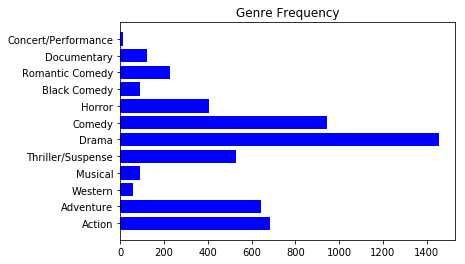

In [17]:
with open('movie_categories.pkl','rb') as f:
    cate_info=pickle.load(f)

dic=cate_info['Genre']
name_list =  list(dic.keys())
num_list = [len(a) for a in dic.values()]
plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
plt.title('Genre Frequency')
plt.show()

To convert text features like keywords, genre and movie staff to numeric information, we define the following way to calculate the influence factor of these features.

For example, the company feature, we model the average past box office performance the company produced as the influcence factor the company contribute to the final box office. The formula is as following:

$$
IF_i=log(\frac{\sum_{(i,j)\in D} BF_{j}}{|D_{(i,j)}|+0.1 }+1)
$$
where the $BF_j$ means the box office of movie $ M_j$.

$D_{(i,j)}$ means the company $C_i$ produced the movie $M_j$ in the dataset. 

The following is the code implementation and the visualization result. To run the code, you may need to download the [movie_info.pkl](https://github.com/yuechaohou/PDS-Final-Project/blob/master/feature_selection/movie_info.pkl), [person_info.pkl](https://github.com/yuechaohou/PDS-Final-Project/blob/master/feature_selection/person_info.pkl) and [name_url.pkl](https://github.com/yuechaohou/PDS-Final-Project/blob/master/feature_selection/name_url.pkl)

[('China Film Company', 20.409429556800788), ('Wanda Pictures', 20.42585515967782), ('Syncopy', 20.460710614331887), ('Fuji Television Network', 20.507848280283877), ('Lightstorm Entertainment', 20.542933952125612), ('Duncan Henderson Productions', 20.602386917266767), ('Tom DeSanto', 20.644304453252747), ('Don Murphy', 20.644304453252747), ('Eon Productions', 20.66953745286486), ('B23', 20.732790318452746)]
2739


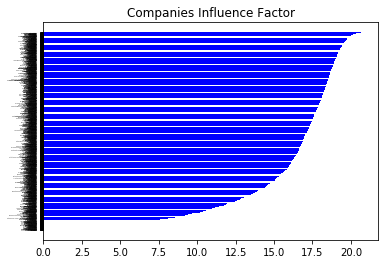

In [18]:
import math
with open('movie_info.pkl','rb') as f:
    movie_info=pickle.load(f)
    
with open('name_url.pkl','rb') as f:
    movie_budget=pickle.load(f)
    
def get_company_info_helper(name, movie_info=movie_info, movie_budget=movie_budget):
    
    company_name_info=dict()
    cast_dic=movie_info[name]['summary']
    if name in movie_budget.keys() and movie_budget[name]['Release Date']<datetime.now():
        if 'Production Companies' in cast_dic.keys():
            for company in cast_dic['Production Companies']:
                #print(name, company.strip())
                bo=movie_budget[name]['Worldwide Gross']
                company_name_info[company.strip()]=company_name_info.get(company.strip(),[])+[bo]
    
    return company_name_info

def get_all_company_info():
    with open('movie_info.pkl', 'rb') as f:
        movie_info=pickle.load(f)
    
    total_dic=dict()
    keys=list(movie_info.keys())
    pool = Pool(processes=10)
    pool_outputs = pool.map(get_company_info_helper,keys)
    pool.close()
    pool.join()
    
    for item in pool_outputs:
        for key, value in item.items():
            total_dic[key.strip()]=total_dic.get(key.strip(),[])+value
    
    #pprint(total_dic)
    company_info=dict()
    for key,value in total_dic.items():
        company_info[key]=math.log(np.sum(np.array(value))/(len(value)+0.1)+1)
    
    with open('company_info.pkl','wb') as f:
        pickle.dump(company_info, f)
        
    return    

get_all_company_info()
with open('company_info.pkl', 'rb') as f:
    company_info=pickle.load(f)

sorted_company=sorted(company_info.items(), key=lambda d: d[1])
print(sorted_company[-10:])

print(len(sorted_company))
target=sorted_company
name_list = [a[0] for a in target]
num_list = [a[1] for a in target]
plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
plt.tick_params(axis='y',labelsize=1)
plt.title('Companies Influence Factor')
plt.show()

Totally, there are 2739 companies. The top first company with the highest influence factor is B23, who produced Skyfall in 2012 together with Eon Productions, Metro-Goldwyn-Mayer Pictures and Columbia Pictures.

We did similar calculation of influence factors for movie staff, keywords, production method, franchise, creative type and genre. You can find all the code from [here](https://github.com/yuechaohou/PDS-Final-Project/blob/master/feature_selection/Feature%20Selection.ipynb).

We selected budget, movie staff, keywords, production method, franchise, creative type, genre and production companies as the features to pass to our model. We exclude the movie with missing information and convert different features to the influence factor as we defined above.

In [19]:
visual_list=dict()

with open('movie_info.pkl', 'rb') as f:
    movie_info=pickle.load(f)
    
with open('person_info.pkl', 'rb') as f:
    person_info=pickle.load(f)
    
with open('name_url.pkl', 'rb') as f:
    movie_budget=pickle.load(f)

visual_y=list()
movie_name=list()
visual_list['budget']=list()
visual_list['cast']=list()
total_info=dict()
key_list=['Keywords', 'Production Method', 'Franchise', 'Creative Type', 'Genre', 'Production Companies']
for key in key_list:
    file_name='_'.join(key.lower().split())
    visual_list[file_name]=list()
    with open(file_name+'.pkl','rb') as f:
        total_info[file_name]=pickle.load(f)

for name in movie_info.keys():
    cast_dic=movie_info[name]['cast']
    cast_list=['leading_members', 'production']
    if name in movie_budget.keys() and movie_budget[name]['Release Date']<datetime.now():
        movie_name.append(name)
        test_value=math.log(movie_budget[name]['Worldwide Gross']+1)
        if test_value<15:
            visual_y.append('r')
        elif test_value<18:
            visual_y.append('b')
        else:
            visual_y.append('g')
            
        tmplist=list()
        for cate in cast_list:
            if cate in cast_dic.keys():
                for person in cast_dic[cate]:
                    person_name=person['name'].strip()
                    tmplist.append(person_info[person_name])
        
        visual_list['cast'].append(np.mean(np.array(tmplist)))
        visual_list['budget'].append(movie_budget[name]['Production Budget'])
        
        key_list=['Franchise', 'Creative Type', 'Genre']
        for key in key_list:
            file_name='_'.join(key.lower().split())
            if key in movie_info[name]['summary'].keys():
                cate=movie_info[name]['summary'][key].strip()
                visual_list[file_name].append(total_info[file_name][cate])
            else:
                visual_list[file_name].append(np.mean(np.array(list(total_info[file_name].values()) )))
        
        key_list=['Keywords', 'Production Method','Production Companies']
        for key in key_list:
            file_name='_'.join(key.lower().split())
            tmplist=list()
            if key in movie_info[name]['summary'].keys():
                for cate in movie_info[name]['summary'][key]:
                    tmplist.append(total_info[file_name][cate.strip()])
                visual_list[file_name].append(np.mean(np.array(tmplist)))
            else:
                visual_list[file_name].append(np.mean(np.array(list(total_info[file_name].values()) )))
                
P=np.array(list(visual_list.values())).T
column_name=np.array(list(visual_list.keys()))
visual_y=np.array(visual_y)
movie_name=np.array(movie_name)
movie_name=movie_name[~np.isnan(P).any(axis=1)]
y_train=visual_y[~np.isnan(P).any(axis=1)]
P=P[~np.isnan(P).any(axis=1)]
pdf=pd.DataFrame(data=P,index=movie_name, columns=column_name)
pdf.index.rename('name', inplace=True)
pdf.to_csv('movie_info.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'person_info.pkl'

## Data visualization and analysis

In this part, we tried to visualize our dataset with different methods. In the first method, We tried to visualize the movie node with movie information as a 3-dimensional point. We used PCA to reduce the deminsion to 3 deminsion and label movies with different level of box office with different colors. The visualization is shown as following.

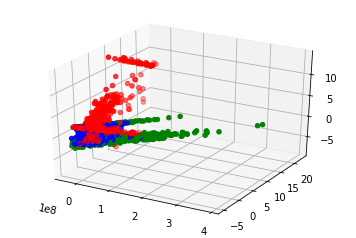

In [4]:
pca = PCA(n_components=3)
pca.fit(P)
P=pca.transform(P)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(P[:,0],P[:,1],P[:,2], c=y_train)
plt.show()

From the figure above, we can see that movies with the same level of box office approximately cluster together except for some outliers.

In another method, we tried to visualize the dataset as a network. We assume each row of data as a high-deminsional point and calculate the distance between each two points. If the distance is less than a threshold, we add an edge between the two points. The result is shown as following.

In [10]:
import networkx as nx

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx
import scipy.spatial.distance as sp
from sklearn.preprocessing import normalize

data=pd.read_csv('movie_info.csv')
data=data.loc[:, data.columns != 'name'].as_matrix()
n=len(data)
threshold=100
dmatrix=np.zeros((n,n))
distance=sp.cdist(data,data)
print('starting')
for i in range(n):
    for j in range(n):
        if distance[i,j]<=threshold:
            dmatrix[i,j]=1

print('ending')
G=nx.from_numpy_matrix(dmatrix)
plot = figure(title="Network of Movie Nodes", x_range=(-0.5,0.5), y_range=(-0.5,0.5))

graph = from_networkx(G, nx.spring_layout, scale=3, center=(0,0))
plot.renderers.append(graph)

output_notebook()
print('visualizing')
show(plot)

starting
ending


Loading BokehJS ...

visualizing


/anaconda3/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


From the visualization above we can see that even though some movie nodes cluster together, overally the movie nodes are scattered. 

## Reference
